In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

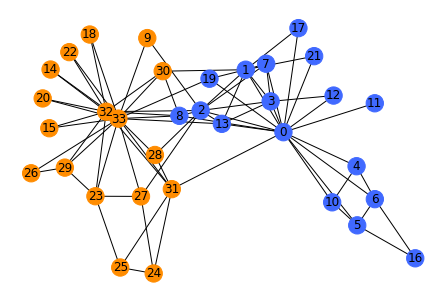

In [47]:
G = nx.karate_club_graph()

cmap = []
for n in G.nodes:
    if G.nodes[n]['club'] == 'Mr. Hi':
        cmap.append([0.25,0.41,1.00])
    elif G.nodes[n]['club'] == 'Officer':
        cmap.append([1.00,0.55,0.00])
nx.draw(G, with_labels=True, node_color=cmap)
plt.show()
# evidently, the graph is pretty well separated without doing anything at all

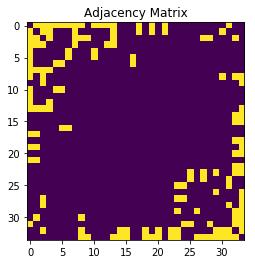

In [53]:
# create an adjacency matrix
A = nx.to_numpy_matrix(G, nodelist=G.nodes())
plt.imshow(A)
plt.title('Adjacency Matrix');

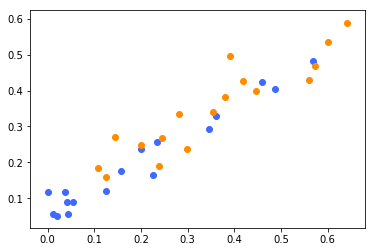

In [71]:
A_h = A + np.eye(G.number_of_nodes())
D_h = np.array(np.sum(A_h, axis=0))[0]
D_h = np.matrix(np.diag(D_h))

# randomly initialied weights
# we're trying to project the graph down to a 2D feature-space
W_1 = np.random.normal(loc=0, scale=1, size=(G.number_of_nodes(), 4))
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2))

def relu(x):
    return np.maximum(x, 0.)

def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)

H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

fig, ax = plt.subplots(1,1)
for i in range(G.number_of_nodes()):
    ax.scatter(output[i,0], output[i,1], color=cmap[i])

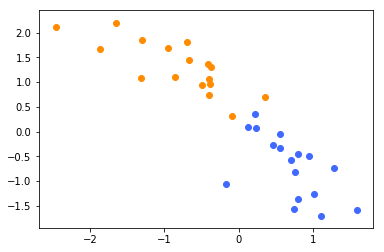

In [161]:
import torch
import torch.nn.functional as F

class GraphNet(torch.nn.Module):
    def __init__(self, N, A):
        super(GraphNet, self).__init__()
        temp = torch.randn((N, 8), dtype = torch.float64)
        self.W1 = torch.autograd.Variable(temp, requires_grad=True)
        temp = torch.randn((8, 2), dtype = torch.float64)
        self.W2 = torch.autograd.Variable(temp, requires_grad=True)
        
        A_h = A + np.eye(N)
        D = np.array(np.sum(A_h, axis=0))[0]
        D_i = np.diag(D ** (-0.5))
        DAD = D_i * A_h * D_i
        self.DAD = torch.tensor(DAD)
        
    def forward(self, x):
        x = torch.mm(self.DAD,x)
        x = torch.mm(x, self.W1)
        x = F.relu(x)
        x = torch.mm(self.DAD,x)
        x = torch.mm(x, self.W2)
        
        return x
    
# first create a label vector
labels = torch.zeros(G.number_of_nodes(), dtype=torch.int64)
i = 0
for n in G.nodes:
    if G.nodes[n]['club'] == 'Mr. Hi':
        labels[i] = 0
    elif G.nodes[n]['club'] == 'Officer':
        labels[i] = 1
    i = i + 1
    
# next create a feature vector. The simplest thing to do is just use an identity matrix
# it deosn't really convey any information, in practice you'd use something better
inputs = torch.tensor(np.eye(G.number_of_nodes()))

gcn = GraphNet(G.number_of_nodes(), A)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([gcn.W1, gcn.W2], lr=1e-2)

epochs = 30
loss_chart = np.zeros(epochs)
for e in range(epochs):    
    optimizer.zero_grad()
    output = gcn(inputs)
    loss = loss_func(output, labels)
    loss.backward()
    optimizer.step()
    
    loss_chart[e] = loss.item()

output = output.detach().numpy()

fig, ax = plt.subplots(1,1)
for i in range(G.number_of_nodes()):
    ax.scatter(output[i,0], output[i,1], color=cmap[i])